# 🎓 Independent Component Analysis (ICA) from Scratch

---

## Step 1. Imports

We import the necessary Python libraries:  
- **NumPy** for numerical computations  
- **Matplotlib** for visualizations  

---

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Make plots a bit nicer
plt.style.use("seaborn-v0_8")



## Step 2. Generate Independent Sources

We create three independent signals:  
1. A **sine wave**  
2. A **square wave**  
3. A **Laplace-distributed noise signal**  

These will be our **true sources** that ICA should recover.  

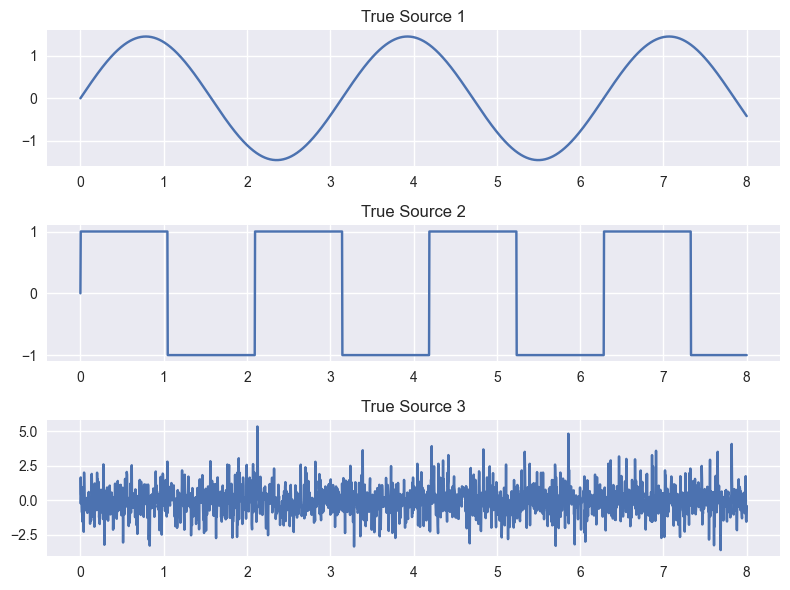

In [18]:
np.random.seed(42)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

# Three independent sources
s1 = np.sin(2 * time)                  # Sine wave
s2 = np.sign(np.sin(3 * time))         # Square wave
s3 = np.random.laplace(size=n_samples) # Non-Gaussian noise

# Stack into matrix
S = np.c_[s1, s2, s3]
S /= S.std(axis=0)  # Standardize each signal

# Plot
fig, ax = plt.subplots(3, 1, figsize=(8, 6))
for i in range(3):
    ax[i].plot(time, S[:, i])
    ax[i].set_title(f"True Source {i+1}")
plt.tight_layout()
plt.show()


## Step 3. Mix the Signals

We define a mixing matrix \( A \).  
The observed mixtures are:  

$X = S A^T$

This simulates how microphones record overlapping signals in a room.

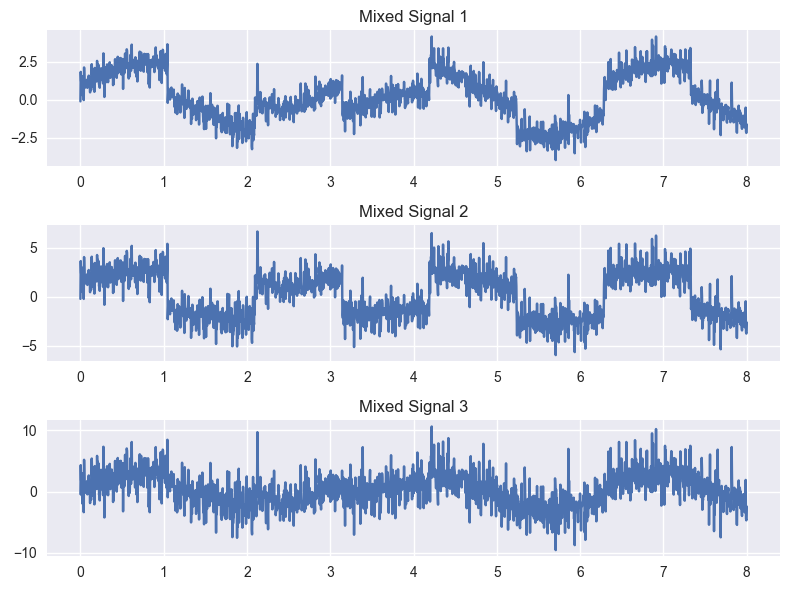

In [19]:
# Mixing matrix
A = np.array([[1, 1, 0.5],
              [0.5, 2, 1.0],
              [1.5, 1.0, 2.0]])

# Mixtures
X = S @ A.T

# Plot
fig, ax = plt.subplots(3, 1, figsize=(8, 6))
for i in range(3):
    ax[i].plot(time, X[:, i])
    ax[i].set_title(f"Mixed Signal {i+1}")
plt.tight_layout()
plt.show()


## Step 4. Center and Whiten

- **Centering**: subtract the mean of each signal.  
- **Whitening**: decorrelate the signals and scale them to have unit variance.  

After whitening:  

$\text{Cov}(X_{\text{white}}) = I$

This simplifies ICA to finding an **orthogonal rotation** that makes components independent.  


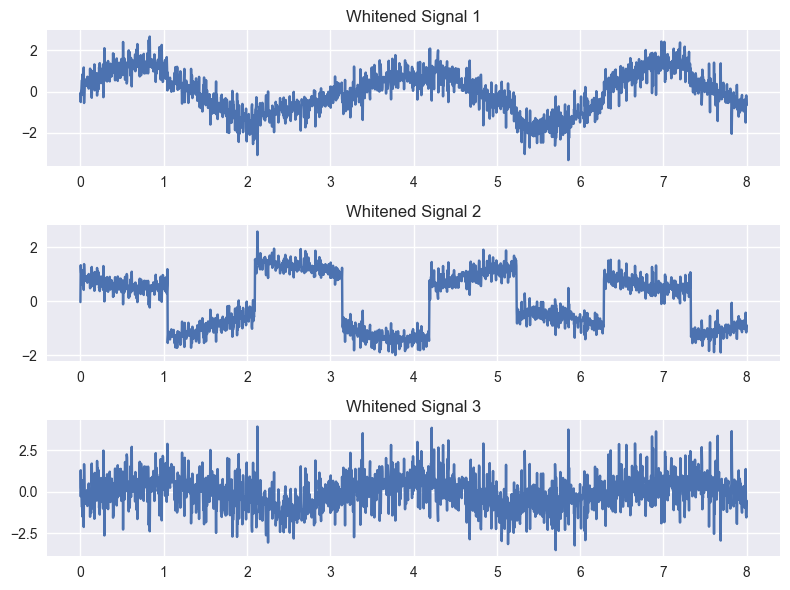

In [20]:
# Center (zero mean)
X_centered = X - X.mean(axis=0)

# Whitening (decorrelate and normalize variance)
cov = np.cov(X_centered, rowvar=False)
E, D, _ = np.linalg.svd(cov)   # eigen decomposition
D_inv = np.diag(1.0 / np.sqrt(D))
X_white = X_centered @ E @ D_inv @ E.T

# Plot whitened signals
fig, ax = plt.subplots(3, 1, figsize=(8, 6))
for i in range(3):
    ax[i].plot(time, X_white[:, i])
    ax[i].set_title(f"Whitened Signal {i+1}")
plt.tight_layout()
plt.show()


## Step 5. Define Nonlinearity

ICA uses the fact that **linear mixtures of independent signals tend to look Gaussian** (Central Limit Theorem).  
So we look for directions that are **maximally non-Gaussian**.  

We use a nonlinear function $g(u) = \tanh(u)$ to measure non-Gaussianity. 

In [21]:
def g(u):
    """Nonlinear function (tanh)"""
    return np.tanh(u)

def g_prime(u):
    """Derivative of g"""
    return 1.0 - np.tanh(u) ** 2


## Step 6. ICA Algorithm (Fixed-Point Iteration)

The ICA algorithm proceeds as follows for each component:  

1. Start with a random weight vector $w$.  
2. Update it using the rule:  

$w_{\text{new}} = \mathbb{E}[x g(w^T x)] - \mathbb{E}[g'(w^T x)] w$

3. Decorrelate it from previously found components.  
4. Normalize the vector.  
5. Repeat until convergence.  

This is the **core fixed-point iteration** (similar to FastICA, but implemented manually).  


In [22]:
def ica(X, n_components, n_iter=500, tol=1e-5):
    n_samples, n_features = X.shape
    W = np.zeros((n_components, n_features))  # Unmixing matrix

    for i in range(n_components):
        w = np.random.rand(n_features)
        w /= np.linalg.norm(w)

        for _ in range(n_iter):
            # Update
            w_new = (X * g(X @ w)[:, np.newaxis]).mean(axis=0) - g_prime(X @ w).mean() * w

            # Decorrelate from previous components
            if i > 0:
                w_new -= W[:i].T @ (W[:i] @ w_new)

            # Normalize
            w_new /= np.linalg.norm(w_new)

            # Convergence check
            if np.abs(np.abs(np.dot(w, w_new)) - 1) < tol:
                break
            w = w_new

        W[i, :] = w

    return W


## Step 7. Run ICA

We compute the unmixing matrix $W$.  
The recovered sources are then:  

$S_{\text{est}} = X_{\text{white}} W^T$

These should look similar to the original sources, except for **order** (permutation) and **sign** (scaling).  


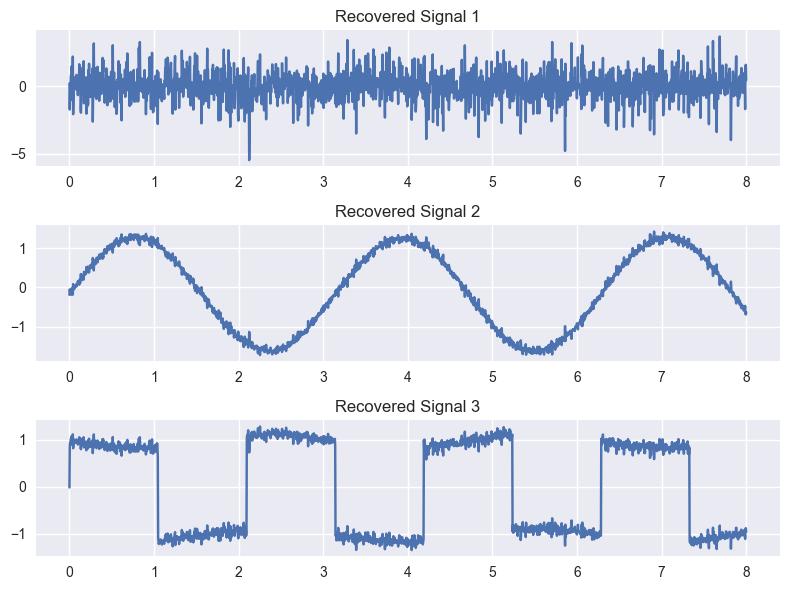

In [23]:
# Compute unmixing matrix
W = ica(X_white, n_components=3)

# Recover sources
S_est = X_white @ W.T

# Plot recovered signals
fig, ax = plt.subplots(3, 1, figsize=(8, 6))
for i in range(3):
    ax[i].plot(time, S_est[:, i])
    ax[i].set_title(f"Recovered Signal {i+1}")
plt.tight_layout()
plt.show()


## Step 8. Compare All Together

Finally, we visualize all signals side by side:  

- **True sources** (the independent signals we generated)  
- **Mixed signals** (what microphones record)  
- **Recovered signals** (output of ICA)  


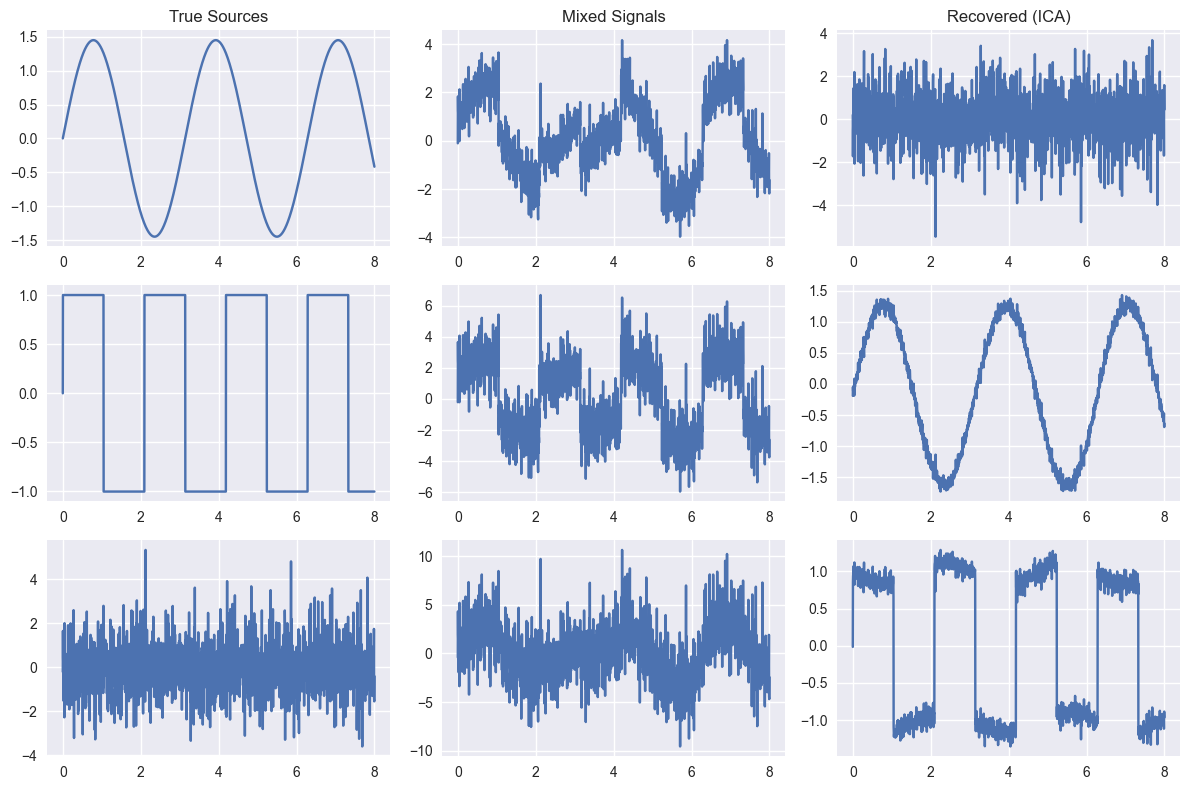

In [24]:
fig, axes = plt.subplots(3, 3, figsize=(12, 8))

titles = ["True Sources", "Mixed Signals", "Recovered (ICA)"]

for i, signals in enumerate([S, X, S_est]):
    for j in range(3):
        axes[j, i].plot(time, signals[:, j])
        if j == 0:
            axes[j, i].set_title(titles[i])

plt.tight_layout()
plt.show()


## ✅ Observations

- ICA successfully recovers the independent signals.  
- The order of the signals may be different (**permutation ambiguity**).  
- The sign of the signals may be flipped (**scaling ambiguity**).  
- Despite these ambiguities, ICA finds statistically **independent components**.